In [31]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

import starfile

In [32]:
def point_in_ConvexHull(hull, pnt):
    '''
    Checks if `pnt` is inside the convex hull.
    `hull` -- a QHull ConvexHull object
    `pnt` -- point array of shape (3,)
    '''
    new_hull = ConvexHull(np.concatenate((hull.points, [pnt])))
    if np.array_equal(new_hull.vertices, hull.vertices): 
        return True
    return False

In [33]:
#all_particles_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/preclass_job282_run_data.star")
#aligning_particles_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/postclass_job292_run_data.star")

classified_particles_star_path= Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/job290_run_it050_data.star")
aligning_class_number = 7

binning = 10
max_x = 818 * binning
max_y = 1152 * binning
max_z = 480 * binning
tomo_dir = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/surfaces_all/bottom")

unbinned_pixel_size = 1.0825 # A/px
increment_nm = 10
distance_to_top_nm = 350
increment_px = increment_nm * 10 / unbinned_pixel_size
increments_below_bottom = 50 / increment_nm # nm above the top layer
num_layers = int((50 + distance_to_top_nm) / increment_nm)

# Where previous analysis results are saved
saved_all_particles_star_path = tomo_dir / "all_particles_context.star"
saved_aligning_particles_star_path = tomo_dir / "aligning_particles_context.star"


In [34]:
# Read in the particle star file
classified_particles_star = starfile.read(classified_particles_star_path)
classified_particles_df = classified_particles_star["particles"]

all_particles_df = classified_particles_df
aligning_particles_df = classified_particles_df[classified_particles_df["rlnClassNumber"] == aligning_class_number]
# place points along the edge of the box every 100 px
topboundary_points = [[x, 0, max_z] for x in range(0, max_x, 100)] + \
    [[max_x, 0, max_z]] + \
    [[x, max_y, max_z] for x in range(0, max_x, 100)] + \
    [[0, y, max_z] for y in range(0, max_y, 100)] + \
    [[max_x, y, max_z] for y in range(0, max_y, 100)] + \
    [[max_x, max_y, max_z]]

topboundary_points_df = pd.DataFrame(topboundary_points, columns=["x", "y", "z"])
bottomboundary_points = [[x, 0, 0] for x in range(0, max_x, 100)] + \
    [[max_x, 0, 0]] + \
    [[x, max_y, 0] for x in range(0, max_x, 100)] + \
    [[0, y, 0] for y in range(0, max_y, 100)] + \
    [[max_x, y, 0] for y in range(0, max_y, 100)] + \
    [[max_x, max_y, 0]]
bottomboundary_points_df = pd.DataFrame(bottomboundary_points, columns=["x", "y", "z"])

In [35]:
tomo_list = [tomo.name[:6] for tomo in sorted(tomo_dir.glob("*.mod"))]

all_particles_df["LayerNumFromBottom"] = None
aligning_particles_df["LayerNumFromBottom"] = None
all_particles_to_check_df = all_particles_df[all_particles_df["rlnTomoName"].isin(tomo_list)]
aligning_particles_to_check_df = aligning_particles_df[aligning_particles_df["rlnTomoName"].isin(tomo_list)]

/tmp/ipykernel_2559394/3458919944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aligning_particles_df["LayerNumFromBottom"] = None


In [36]:
one_iter = False

all_particles_layer_df = pd.DataFrame(data={"count": np.zeros(num_layers, dtype=int)})
aligning_particles_layer_df = pd.DataFrame(data={"count": np.zeros(num_layers, dtype=int)})
all_particles_analyzed_df = pd.DataFrame()
aligning_particles_analyzed_df = pd.DataFrame()

for tomo_name in tomo_list:
    print(tomo_name)
    all_particles_tomo_df = all_particles_to_check_df[all_particles_to_check_df["rlnTomoName"] == tomo_name]
    aligning_particles_tomo_df = aligning_particles_to_check_df[aligning_particles_to_check_df["rlnTomoName"] == tomo_name]
    print(f"Total particles in {tomo_name} = {len(all_particles_tomo_df)}")
    print(f"Well aligning particles in {tomo_name} = {len(aligning_particles_tomo_df)}")


    bottom_points_file = tomo_dir / f"{tomo_name}_bot.xyz"
    bottom_points_df = pd.read_csv(bottom_points_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * binning
    bottom_points_df["z"] = bottom_points_df["z"] - increments_below_bottom*increment_px
    bottom_points_df = pd.concat([bottom_points_df, bottomboundary_points_df])

    # Starting at the bottom air-water interface, go down in increments of 10 nm.
    # For each increment, check if the particle is inside the convex hull of the surface.
    # If it is, assign the particle to the context of the surface.
    # If it is not, continue to the next increment.

    for layer in range(num_layers):

        # We are starting increments_below_bottom layers above where the bottom surface is defined

        bottom_ConvexHull = ConvexHull(bottom_points_df)

        # Check if each particle is inside the convex hull
        for i, particle in all_particles_tomo_df.iterrows():
            if particle["LayerNumFromBottom"] is not None:
                continue
            particle_coords = np.array([particle["rlnCoordinateX"], particle["rlnCoordinateY"], particle["rlnCoordinateZ"]])
            #print(particle_coords)
            if point_in_ConvexHull(bottom_ConvexHull, particle_coords):
                #print(f"Particle {i} is in layer {layer}")
                # Set the "LayerNumFromBottom" of the particle to the layer number
                all_particles_tomo_df.at[i, "LayerNumFromBottom"] = layer

        # print the total number of particles found in this layer

        for i, particle in aligning_particles_tomo_df.iterrows():
            if particle["LayerNumFromBottom"] is not None:
                continue
            particle_coords = np.array([particle["rlnCoordinateX"], particle["rlnCoordinateY"], particle["rlnCoordinateZ"]])
            if point_in_ConvexHull(bottom_ConvexHull, particle_coords):
                aligning_particles_tomo_df.at[i, "LayerNumFromBottom"] = layer
        
        all_particles_layer_df.at[layer, "count"] += len(all_particles_tomo_df[all_particles_tomo_df["LayerNumFromBottom"] == layer])
        aligning_particles_layer_df.at[layer, "count"] += len(aligning_particles_tomo_df[aligning_particles_tomo_df["LayerNumFromBottom"] == layer])
        bottom_points_df["z"] += increment_px
    all_particles_analyzed_df = pd.concat([all_particles_analyzed_df, all_particles_tomo_df])
    aligning_particles_analyzed_df = pd.concat([aligning_particles_analyzed_df, aligning_particles_tomo_df])
    if one_iter == True:
        break

ts_003
Total particles in ts_003 = 394
Well aligning particles in ts_003 = 384
ts_004
Total particles in ts_004 = 911
Well aligning particles in ts_004 = 865
ts_005
Total particles in ts_005 = 255
Well aligning particles in ts_005 = 188
ts_006
Total particles in ts_006 = 425
Well aligning particles in ts_006 = 420
ts_007
Total particles in ts_007 = 405
Well aligning particles in ts_007 = 321
ts_008
Total particles in ts_008 = 106
Well aligning particles in ts_008 = 35
ts_009
Total particles in ts_009 = 174
Well aligning particles in ts_009 = 52
ts_012
Total particles in ts_012 = 80
Well aligning particles in ts_012 = 6
ts_013
Total particles in ts_013 = 193
Well aligning particles in ts_013 = 125
ts_014
Total particles in ts_014 = 237
Well aligning particles in ts_014 = 146
ts_015
Total particles in ts_015 = 743
Well aligning particles in ts_015 = 211
ts_016
Total particles in ts_016 = 325
Well aligning particles in ts_016 = 125
ts_017
Total particles in ts_017 = 37
Well aligning parti

In [37]:
all_particles_layer_df

,count
0,47
1,8
2,9
3,22
4,71
5,106
6,126
7,171
8,199
9,187


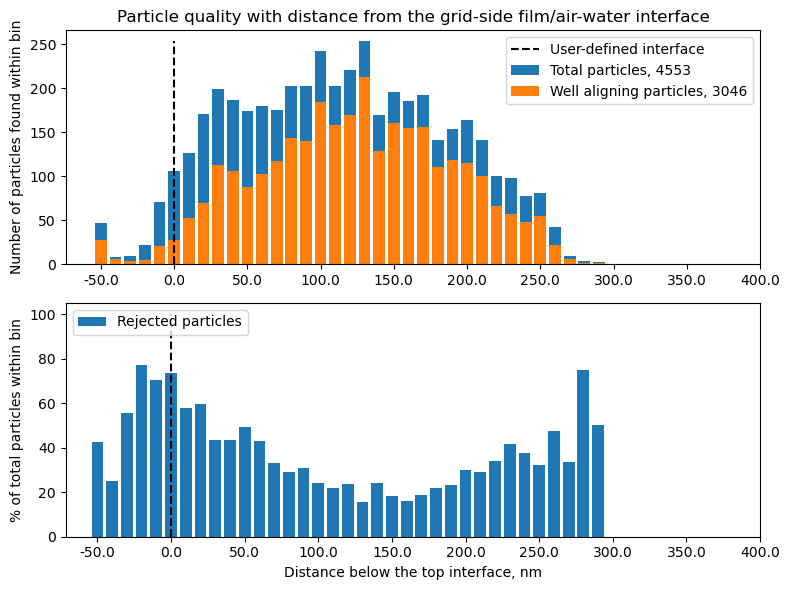

In [41]:
# 2 plots of  the number of particles in each layer
plt.rcParams.update({'font.size': 10})
#fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(10, 10))
fig, [ax1,ax3] = plt.subplots(2, 1, figsize=(8, 6))

#all_particles_layer_df = pd.read_csv(tomo_dir / "preclassif288_context.csv")
#aligning_particles_layer_df = pd.read_csv(tomo_dir / "postclassif288_context.csv")

ax1.bar(all_particles_layer_df.index, all_particles_layer_df["count"], label=f"Total particles, {all_particles_layer_df['count'].sum()}") 
ax1.bar(aligning_particles_layer_df.index, aligning_particles_layer_df["count"], label=f"Well aligning particles, {aligning_particles_layer_df['count'].sum()}")
# Sum up all the particles in the layers
ax1.vlines(increments_below_bottom, 0, all_particles_layer_df["count"].max(), colors="k", linestyles="dashed", label="User-defined interface")
ax1.set_xticks(np.arange(0, num_layers+6, 5))
ax1.set_xticklabels([f"{(i-increments_below_bottom) * increment_nm}" for i in ax1.get_xticks()])
ax1.set_ylabel("Number of particles found within bin")
ax1.set_title(f"Particle quality with distance from the grid-side film/air-water interface")
#ax1.set_ylim(0, 20)
ax1.legend()


# ax2.bar(all_particles_layer_df.index, all_particles_layer_df["count"] - aligning_particles_layer_df["count"], label="Rejected particles")
# # gray dashed line at 1.0
# ax2.vlines(increments_below_bottom, 0, 200, colors="k", linestyles="dashed")
# ax2.set_ylabel("Number of particles within bin")
# ax2.set_xticks(np.arange(0, num_layers+6, 5))
# ax2.set_xticklabels([f"{(i-increments_below_bottom) * increment_nm}" for i in ax2.get_xticks()])
# ax2.legend()
# plot % difference and put the units on the right y-axis
ax3.bar(all_particles_layer_df.index, (all_particles_layer_df["count"] - aligning_particles_layer_df["count"]) / all_particles_layer_df["count"] * 100, label="Rejected particles")
ax3.vlines(increments_below_bottom, 0, 100, colors="k", linestyles="dashed")
ax3.set_xlabel("Distance below the top interface, nm")
# change the tick labels to nm
ax3.set_xticks(np.arange(0, num_layers+6, 5))
ax3.set_xticklabels([f"{(i-increments_below_bottom) * increment_nm}" for i in ax3.get_xticks()])
ax3.set_ylabel("% of total particles within bin")
ax3.set_ylim(0, 105)
#ax1.set_xlim(0, num_layers)
#ax2.set_xlim(0, num_layers)
#ax3.set_xlim(0, num_layers)
ax3.legend()

# save the figure
plt.tight_layout()
plt.savefig(tomo_dir / "particle_context.png")

In [39]:
len(all_particles_df), len(aligning_particles_df)

(23589, 11288)

In [40]:
all_particles_analyzed_df[all_particles_analyzed_df["LayerNumFromTop"] <= 1]

KeyError: 'LayerNumFromTop'

In [ ]:
pre_output_star_path = tomo_dir / "all_particles_context.star"
classified_particles_star["particles"] = all_particles_analyzed_df 
starfile.write(classified_particles_star, pre_output_star_path, overwrite=True)
all_particles_layer_df.to_csv(tomo_dir / "all_particles_context.csv")

post_output_star_path = tomo_dir / "aligning_particles_context.star"
classified_particles_star["particles"] = aligning_particles_analyzed_df 
starfile.write(classified_particles_star, post_output_star_path, overwrite=True)
aligning_particles_layer_df.to_csv(tomo_dir / "aligning_particles_context.csv")